<a href="https://colab.research.google.com/github/Fiat-Anw/Fullstack-DEV_IoT-Final-Project/blob/main/model_comparison_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, random_split

torch.manual_seed(42)

In [4]:
def download_dataset(subset_size, val_size):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

    # Load the full CIFAR-10 training set
    full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Subset the training set
    indices = torch.randperm(len(full_train_set))[:subset_size]
    train_subset = Subset(full_train_set, indices)

    # Split the subset into training and validation sets
    train_size = int((1 - val_size) * subset_size)
    val_size = subset_size - train_size
    train_set, val_set = random_split(train_subset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=False, num_workers=2)

    # Load the full CIFAR-10 test set
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return train_loader, val_loader, test_loader, classes

In [5]:
subset_size = 2000
val_size = 0.2  # 20% for validation
train_loader, val_loader, test_loader, classes = download_dataset(subset_size, val_size)

100%|██████████| 170498071/170498071 [00:05<00:00, 29830087.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [15]:
model0 = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model1 = models.densenet161(weights=models.DenseNet161_Weights.IMAGENET1K_V1)
model2 = models.densenet169(weights=models.DenseNet169_Weights.IMAGENET1K_V1)
model3 = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)

In [16]:
# Modify the output layer to match the target classes
num_classes = 10
model0.classifier = nn.Linear(model0.classifier.in_features, num_classes)
model1.classifier = nn.Linear(model1.classifier.in_features, num_classes)
model2.classifier = nn.Linear(model2.classifier.in_features, num_classes)
model3.classifier = nn.Linear(model3.classifier.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model0.to(device)
model1.to(device)
model2.to(device)
model3.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [17]:
# Trainable layers
for name, param in model0.named_parameters():
    if param.requires_grad:
        print(name)

features.conv0.weight
features.norm0.weight
features.norm0.bias
features.denseblock1.denselayer1.norm1.weight
features.denseblock1.denselayer1.norm1.bias
features.denseblock1.denselayer1.conv1.weight
features.denseblock1.denselayer1.norm2.weight
features.denseblock1.denselayer1.norm2.bias
features.denseblock1.denselayer1.conv2.weight
features.denseblock1.denselayer2.norm1.weight
features.denseblock1.denselayer2.norm1.bias
features.denseblock1.denselayer2.conv1.weight
features.denseblock1.denselayer2.norm2.weight
features.denseblock1.denselayer2.norm2.bias
features.denseblock1.denselayer2.conv2.weight
features.denseblock1.denselayer3.norm1.weight
features.denseblock1.denselayer3.norm1.bias
features.denseblock1.denselayer3.conv1.weight
features.denseblock1.denselayer3.norm2.weight
features.denseblock1.denselayer3.norm2.bias
features.denseblock1.denselayer3.conv2.weight
features.denseblock1.denselayer4.norm1.weight
features.denseblock1.denselayer4.norm1.bias
features.denseblock1.denselaye

In [18]:
def freeze_layers(model, layers_to_freeze):
    for name, param in model.named_parameters():
        param.requires_grad = not any(layer in name for layer in layers_to_freeze)

# Layers to freeze
layers_to_freeze = [
    "features.conv0", "features.norm0", "features.relu0", "features.pool0",
    "features.denseblock1", "features.transition1",
    "features.denseblock2", "features.transition2",
    "features.denseblock3", "features.transition3"
]

freeze_layers(model0, layers_to_freeze)
freeze_layers(model1, layers_to_freeze)
freeze_layers(model2, layers_to_freeze)
freeze_layers(model3, layers_to_freeze)

# Trainable layers
for name, param in model0.named_parameters():
    if param.requires_grad:
        print(name)

features.denseblock4.denselayer1.norm1.weight
features.denseblock4.denselayer1.norm1.bias
features.denseblock4.denselayer1.conv1.weight
features.denseblock4.denselayer1.norm2.weight
features.denseblock4.denselayer1.norm2.bias
features.denseblock4.denselayer1.conv2.weight
features.denseblock4.denselayer2.norm1.weight
features.denseblock4.denselayer2.norm1.bias
features.denseblock4.denselayer2.conv1.weight
features.denseblock4.denselayer2.norm2.weight
features.denseblock4.denselayer2.norm2.bias
features.denseblock4.denselayer2.conv2.weight
features.denseblock4.denselayer3.norm1.weight
features.denseblock4.denselayer3.norm1.bias
features.denseblock4.denselayer3.conv1.weight
features.denseblock4.denselayer3.norm2.weight
features.denseblock4.denselayer3.norm2.bias
features.denseblock4.denselayer3.conv2.weight
features.denseblock4.denselayer4.norm1.weight
features.denseblock4.denselayer4.norm1.bias
features.denseblock4.denselayer4.conv1.weight
features.denseblock4.denselayer4.norm2.weight
fe

In [19]:
def evaluate_model(model, data_loader):
    all_predictions = []
    bool_predictions = []
    model.eval() # Set model to evaluation mode
    model.to(device)
    num_correct = 0
    num_total = 0
    with torch.no_grad(): # Disable gradient computation
        for batch_data in data_loader:
            images, labels = batch_data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs.data, 1)

            num_total += labels.size(0)
            num_correct += (predictions == labels).sum().item()

            for i in range(images.shape[0]):
                all_predictions.append((images[i], predictions[i].item(), labels[i].item()))
                bool_predictions.append(predictions[i].item() == labels[i].item())

    accuracy = 100 * num_correct / num_total
    print("Total :", num_total)
    print("Correct :", num_correct)
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    return [accuracy, all_predictions, bool_predictions]

In [20]:
[initial_accuracy0, initial_all_predictions0, initial_bool_predictions0] = evaluate_model(model0, test_loader)

Total : 10000
Correct : 910
Accuracy of the model on the test images: 9.10%


In [21]:
[initial_accuracy1, initial_all_predictions1, initial_bool_predictions1] = evaluate_model(model1, test_loader)

Total : 10000
Correct : 1153
Accuracy of the model on the test images: 11.53%


In [22]:
[initial_accuracy2, initial_all_predictions2, initial_bool_predictions2] = evaluate_model(model2, test_loader)

Total : 10000
Correct : 1163
Accuracy of the model on the test images: 11.63%


In [23]:
[initial_accuracy3, initial_all_predictions3, initial_bool_predictions3] = evaluate_model(model3, test_loader)

Total : 10000
Correct : 902
Accuracy of the model on the test images: 9.02%


In [24]:
def train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for i, batch_data in enumerate(train_loader, 0):
            inputs, labels = batch_data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimize the parameters
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient computation
            for val_batch_data in val_loader:
                val_inputs, val_labels = val_batch_data
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    print('Finished Training')
    return model, train_losses, val_losses

In [25]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer0 = optim.Adam(filter(lambda p: p.requires_grad, model0.parameters()), lr=0.001)
optimizer1 = optim.Adam(filter(lambda p: p.requires_grad, model1.parameters()), lr=0.001)
optimizer2 = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=0.001)
optimizer3 = optim.Adam(filter(lambda p: p.requires_grad, model3.parameters()), lr=0.001)
num_epochs = 10

In [26]:
model0_finetuned, train_losses0, val_losses0 = train_model(model0, criterion, optimizer0, num_epochs, train_loader, val_loader)

Epoch [1/10], Train Loss: 2.1335, Val Loss: 3.6785
Epoch [2/10], Train Loss: 1.9820, Val Loss: 10.7676
Epoch [3/10], Train Loss: 1.8965, Val Loss: 2.4547
Epoch [4/10], Train Loss: 1.8166, Val Loss: 3.5325
Epoch [5/10], Train Loss: 1.8061, Val Loss: 3.6927
Epoch [6/10], Train Loss: 1.7391, Val Loss: 3.3722
Epoch [7/10], Train Loss: 1.7443, Val Loss: 2.9040
Epoch [8/10], Train Loss: 1.6741, Val Loss: 2.8900
Epoch [9/10], Train Loss: 1.7197, Val Loss: 3.3428
Epoch [10/10], Train Loss: 1.6988, Val Loss: 2.5357
Finished Training


In [27]:
model1_finetuned, train_losses1, val_losses1 = train_model(model1, criterion, optimizer1, num_epochs, train_loader, val_loader)

Epoch [1/10], Train Loss: 2.1669, Val Loss: 58.5699
Epoch [2/10], Train Loss: 1.9443, Val Loss: 29.1682
Epoch [3/10], Train Loss: 1.8562, Val Loss: 9.0131
Epoch [4/10], Train Loss: 1.7734, Val Loss: 7.4499
Epoch [5/10], Train Loss: 1.7449, Val Loss: 39.9730
Epoch [6/10], Train Loss: 1.6352, Val Loss: 18.4510
Epoch [7/10], Train Loss: 1.5737, Val Loss: 20.6707
Epoch [8/10], Train Loss: 1.6242, Val Loss: 12.5277
Epoch [9/10], Train Loss: 1.5340, Val Loss: 6.6460
Epoch [10/10], Train Loss: 1.5435, Val Loss: 9.2470
Finished Training


In [28]:
model2_finetuned, train_losses2, val_losses2 = train_model(model2, criterion, optimizer2, num_epochs, train_loader, val_loader)

Epoch [1/10], Train Loss: 2.2109, Val Loss: 7.6329
Epoch [2/10], Train Loss: 1.9726, Val Loss: 13.1545
Epoch [3/10], Train Loss: 1.8980, Val Loss: 8.6667
Epoch [4/10], Train Loss: 1.7655, Val Loss: 6.7491
Epoch [5/10], Train Loss: 1.7556, Val Loss: 3.6637
Epoch [6/10], Train Loss: 1.7133, Val Loss: 8.3027
Epoch [7/10], Train Loss: 1.6697, Val Loss: 5.5916
Epoch [8/10], Train Loss: 1.6694, Val Loss: 7.9081
Epoch [9/10], Train Loss: 1.6130, Val Loss: 5.9221
Epoch [10/10], Train Loss: 1.6141, Val Loss: 8.2636
Finished Training


In [29]:
model3_finetuned, train_losses3, val_losses3 = train_model(model3, criterion, optimizer3, num_epochs, train_loader, val_loader)

Epoch [1/10], Train Loss: 2.1087, Val Loss: 11.3699
Epoch [2/10], Train Loss: 1.9741, Val Loss: 14.4810
Epoch [3/10], Train Loss: 1.9512, Val Loss: 2.5963
Epoch [4/10], Train Loss: 1.8583, Val Loss: 6.9259
Epoch [5/10], Train Loss: 1.7806, Val Loss: 5.3863
Epoch [6/10], Train Loss: 1.7388, Val Loss: 5.9546
Epoch [7/10], Train Loss: 1.7075, Val Loss: 3.2123
Epoch [8/10], Train Loss: 1.6856, Val Loss: 3.7752
Epoch [9/10], Train Loss: 1.6749, Val Loss: 5.3719
Epoch [10/10], Train Loss: 1.6314, Val Loss: 5.6446
Finished Training


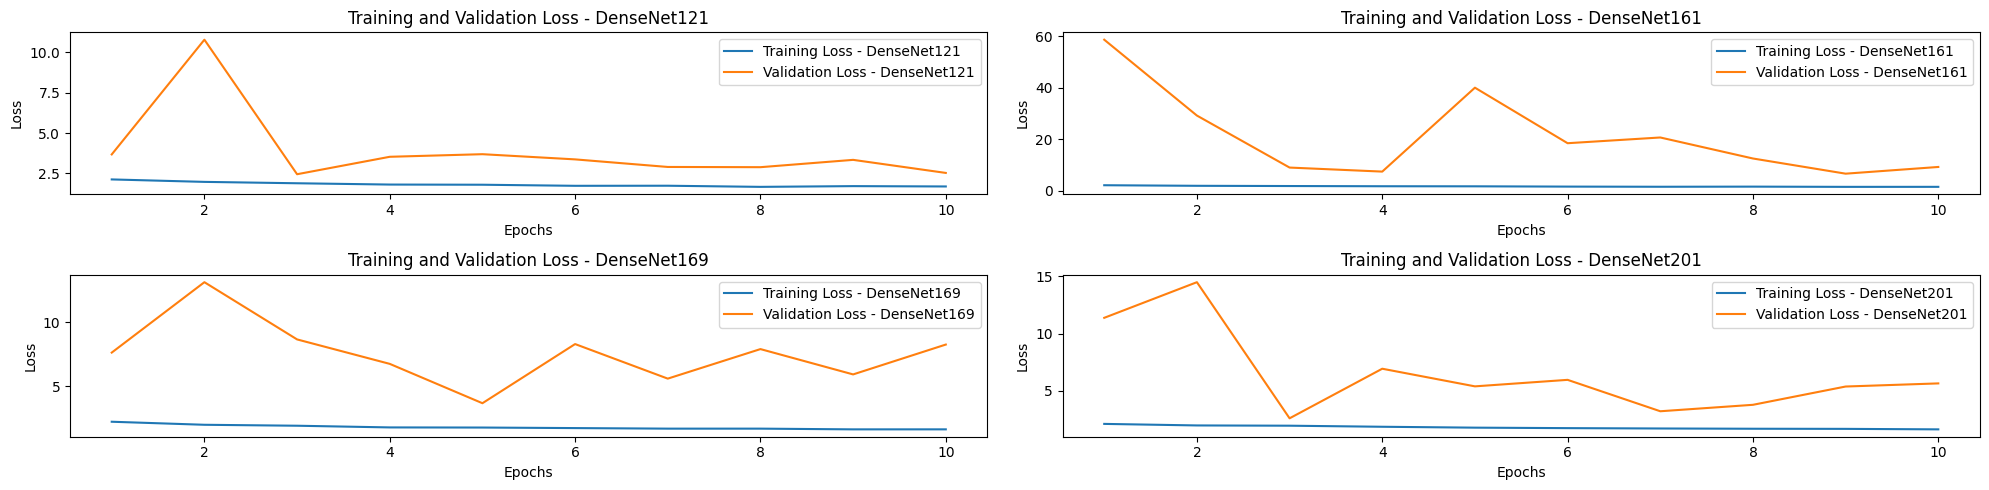

In [31]:
num_epochs = len(train_losses0)  # assuming both have the same number of epochs

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 5))

# Plot training and validation curves for DenseNet121
axes[0, 0].plot(range(1, num_epochs + 1), train_losses0, label='Training Loss - DenseNet121')
axes[0, 0].plot(range(1, num_epochs + 1), val_losses0, label='Validation Loss - DenseNet121')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss - DenseNet121')
axes[0, 0].legend()

# Plot training and validation curves for DenseNet161
axes[0, 1].plot(range(1, num_epochs + 1), train_losses1, label='Training Loss - DenseNet161')
axes[0, 1].plot(range(1, num_epochs + 1), val_losses1, label='Validation Loss - DenseNet161')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Training and Validation Loss - DenseNet161')
axes[0, 1].legend()

# Plot training and validation curves for DenseNet169
axes[1, 0].plot(range(1, num_epochs + 1), train_losses2, label='Training Loss - DenseNet169')
axes[1, 0].plot(range(1, num_epochs + 1), val_losses2, label='Validation Loss - DenseNet169')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training and Validation Loss - DenseNet169')
axes[1, 0].legend()

# Plot training and validation curves for DenseNet201
axes[1, 1].plot(range(1, num_epochs + 1), train_losses3, label='Training Loss - DenseNet201')
axes[1, 1].plot(range(1, num_epochs + 1), val_losses3, label='Validation Loss - DenseNet201')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Training and Validation Loss - DenseNet201')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

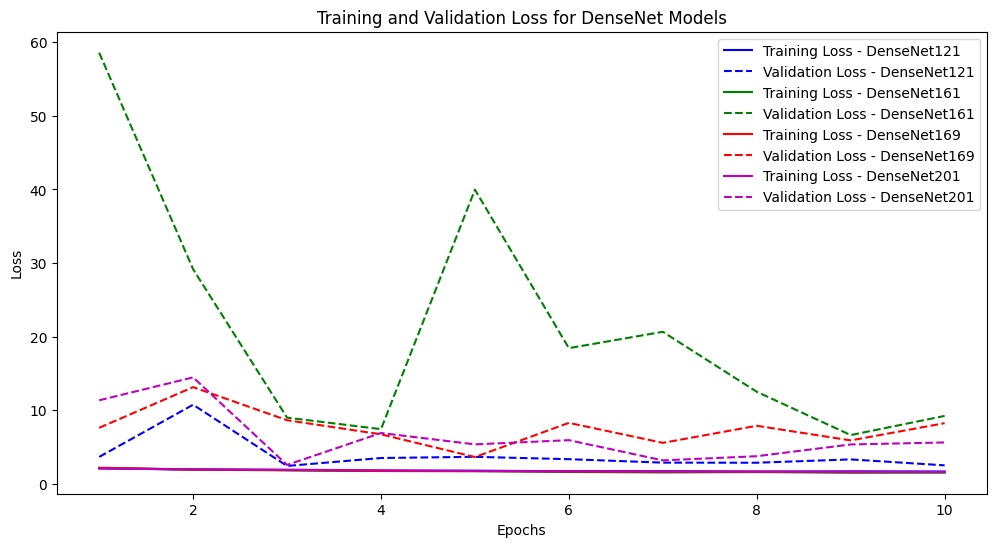

In [35]:
import matplotlib.pyplot as plt

# Number of epochs
num_epochs = len(train_losses0)  # assuming all have the same number of epochs

# Create a single plot
plt.figure(figsize=(12, 6))

# Plot training and validation curves for DenseNet121
plt.plot(range(1, num_epochs + 1), train_losses0, label='Training Loss - DenseNet121', color='b')
plt.plot(range(1, num_epochs + 1), val_losses0, label='Validation Loss - DenseNet121', linestyle='--', color='b')

# Plot training and validation curves for DenseNet161
plt.plot(range(1, num_epochs + 1), train_losses1, label='Training Loss - DenseNet161', color='g')
plt.plot(range(1, num_epochs + 1), val_losses1, label='Validation Loss - DenseNet161', linestyle='--', color='g')

# Plot training and validation curves for DenseNet169
plt.plot(range(1, num_epochs + 1), train_losses2, label='Training Loss - DenseNet169', color='r')
plt.plot(range(1, num_epochs + 1), val_losses2, label='Validation Loss - DenseNet169', linestyle='--', color='r')

# Plot training and validation curves for DenseNet201
plt.plot(range(1, num_epochs + 1), train_losses3, label='Training Loss - DenseNet201', color='m')
plt.plot(range(1, num_epochs + 1), val_losses3, label='Validation Loss - DenseNet201', linestyle='--', color='m')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for DenseNet Models')
plt.legend()

# Show the plot
plt.show()